# Environment Preparation

## Imports

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#display
from tabulate               import tabulate
from IPython.core.display   import HTML
from IPython.display        import Image

# machine learning

# metrics

# handle pickle objects
import pickle

## Path Handlers

In [138]:
datapath = '../data/'
imagepath = '../images/'

## Helper Functions


In [139]:
def jupyter_settings():
    """ Otimiza configurações gerais, padronizanod tamanhos de plots, etc """
    %matplotlib inline
    #%pylab inline - not recommended
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 6]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

def psycopg_connect():
    """"" Creates a psycopg connection from file postgre_credentials """""
    conn = pg.connect(    user = pg_user,
                          password = pg_passwd,
                          host = pg_host,
                          port = pg_port,
                          database = pg_db)
    return conn

# Data Collection


with sqlalchemy - works like a charm, for all dbs

with Psycopg2 - works as well, just for postgreSQL

## With sqlalchemy

In [4]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from postgre_credentials import *

In [5]:
# load from file postgre_credentials
url = 'postgresql://'+pg_user+':'+pg_passwd+'@'+pg_host+':'+pg_port+'/'+pg_db+''

if not database_exists(url):
    #create_database(url)
    print ("database does not exist!")
engine = create_engine(url, pool_size=50, echo=False)

In [6]:
#connected:
#engine.url

In [7]:
#select distinct schemas
query = "SELECT distinct(table_schema) from information_schema.tables"
df = pd.read_sql( query, engine )
df.head(500)

,table_schema
0,public
1,pg_catalog
2,information_schema
3,pa004


In [8]:
#select tables from schema
query = "SELECT * FROM information_schema.tables WHERE table_schema = 'pa004'"
df = pd.read_sql( query, engine )
df.head(500)


,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,comunidadedsdb,pa004,users,BASE TABLE,None,None,None,None,None,YES,NO,None
1,comunidadedsdb,pa004,vehicle,BASE TABLE,None,None,None,None,None,YES,NO,None
2,comunidadedsdb,pa004,insurance,BASE TABLE,None,None,None,None,None,YES,NO,None


In [9]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [10]:
query = """SELECT * FROM pa004.vehicle """
df = pd.read_sql( query, engine )
df.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [11]:
query = """SELECT * FROM pa004.insurance """
df = pd.read_sql( query, engine )
df.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [12]:
#build raw dataset:
query = """

SELECT *
FROM pa004.users u 
INNER JOIN pa004.vehicle v on u.id = v.id 
INNER JOIN pa004.insurance i ON u.id = i.id
ORDER BY u.id

"""
df = pd.read_sql( query, engine )
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,1,> 2 Years,Yes,1,0,40454.0,217,1
1,2,Male,76,3.0,26.0,2,1,1-2 Year,No,2,0,33536.0,183,0
2,3,Male,47,28.0,26.0,3,1,> 2 Years,Yes,3,0,38294.0,27,1
3,4,Male,21,11.0,152.0,4,1,< 1 Year,No,4,1,28619.0,203,0
4,5,Female,29,41.0,152.0,5,1,< 1 Year,No,5,1,27496.0,39,0


In [13]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = pd.read_sql( query, engine )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [14]:
df_raw.shape

(381109, 12)

In [15]:
df_raw.to_csv(datapath+'data_collection_done.csv', index=False)

## With psycopg2

In [16]:
import psycopg2 as pg
from postgre_credentials import *

In [17]:
#Create connection, from Helper Funcions
conn = psycopg_connect()
#conn 

### Schema Query

In [18]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""
cursor.execute( query_schema )

record = cursor.fetchall()
cursor.close()
conn.close()

In [19]:
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

### Table Query

In [20]:
conn = psycopg_connect()
cursor = conn.cursor()

query_tables = """
    SELECT tablename
    FROM pg_tables
    WHERE schemaname='pa004'
"""
cursor.execute( query_tables )

record = cursor.fetchall()
print (record)
cursor.close() #important
conn.close() #important

[('users',), ('vehicle',), ('insurance',)]


### Collect Data using psycopg2 (just sample)

In [21]:
conn = psycopg_connect()
cursor = conn.cursor()

query_table_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    limit 10
"""
cursor.execute( query_table_users )

record = cursor.fetchall()
print (record)
cursor.close() #important
conn.close() #important

[(2, 'Male', 76, 3.0, 26.0), (3, 'Male', 47, 28.0, 26.0), (8, 'Female', 56, 28.0, 26.0), (11, 'Female', 47, 35.0, 124.0), (14, 'Male', 76, 28.0, 13.0), (15, 'Male', 71, 28.0, 30.0), (20, 'Female', 60, 33.0, 124.0), (21, 'Male', 65, 28.0, 124.0), (22, 'Male', 49, 28.0, 124.0), (27, 'Female', 51, 28.0, 124.0)]


In [22]:
data = pd.DataFrame( record )
data.head()
#would need to rename colums each time!

,0,1,2,3,4
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


### Collect Data using Pandas

In [24]:
conn = psycopg_connect()

#sample query
query_table_users = """
    SELECT *
    FROM pa004.users u
    WHERE u.age > 44
    limit 10
"""

df = pd.read_sql( query_table_users, conn )
df.head()

,id,gender,age,region_code,policy_sales_channel
0,2,Male,76,3.0,26.0
1,3,Male,47,28.0,26.0
2,8,Female,56,28.0,26.0
3,11,Female,47,35.0,124.0
4,14,Male,76,28.0,13.0


In [26]:
#build raw dataset:
query_table_users = """
    SELECT *
    FROM pa004.users u 
    LEFT JOIN pa004.vehicle v ON u.id = v.id 
    LEFT JOIN pa004.insurance i ON u.id = i.id 
    ORDER BY u.id
"""

df = pd.read_sql( query_table_users, conn )
df.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,1,> 2 Years,Yes,1,0,40454.0,217,1
1,2,Male,76,3.0,26.0,2,1,1-2 Year,No,2,0,33536.0,183,0
2,3,Male,47,28.0,26.0,3,1,> 2 Years,Yes,3,0,38294.0,27,1
3,4,Male,21,11.0,152.0,4,1,< 1 Year,No,4,1,28619.0,203,0
4,5,Female,29,41.0,152.0,5,1,< 1 Year,No,5,1,27496.0,39,0


In [27]:
# remove duplicate columns (i.e. the 'id' from vehicle and insurance tables)
df_raw = pd.read_sql( query_table_users, conn )
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [28]:
df_raw.shape

(381109, 12)

In [29]:
#same result obtained with sqlarquemy, won't export again
#df_raw.to_csv(datapath+'data_collection_done.csv', index=False)

# Data Description

In [146]:
df1 = pd.read_csv(datapath+'data_collection_done.csv')
df1.head(5)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


In [147]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   region_code           381109 non-null  float64
 4   policy_sales_channel  381109 non-null  float64
 5   driving_license       381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   previously_insured    381109 non-null  int64  
 9   annual_premium        381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## Rename Columns

In [148]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [149]:
df1 = df1.rename(columns={'previously_insured': 'vehicle_prev_insured',
                        'annual_premium': 'health_annual_paid',
                        'vintage': 'days_associated'})
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


## Column Meanings

In [150]:
#Double check understanding of each column

tab = [['Column', 'Meaning'],
    #####################################################  
        ['id', 'unique customer identifier.'],
        ['gender', 'client gender: Male / Female.'],
        ['age', 'customer age.'],
        ['region_code', 'customer region code.'],
        ['policy_sales_channel', 'Anonymized Code for the channel of outreaching to the customer. Ie: Over Mail, Over Phone, In Person, etc..'],
        ['driving_license', '0 = customer does not have DL, 1 = already have DL'],
        ['vehicle_age', 'vehicle age: < 1 Year, 1-2 Year, > 2 Years'],
        ['vehicle_damage', 'No = customer has never had their vehicle damaged in the past, Yes = has had it.'],
        ['vehicle_prev_insured', '0 = customer does not have vehicle insurance, 1= already has vehicle insurance.'],
        ['health_annual_premium', 'annual amount paid by the customer to the company for health insurance. Currency: Rs(Pakistani rupee, R$1.00 = ± Rs0.03).'],
       
        ['days_associated', 'number of days since the customer joined the company by purchasing health insurance. The policy is annual.'],
        ['response', '0 = customer is not interested, 1 = customer is interested.']
      ]
print(tabulate(tab, headers='firstrow', stralign='left', tablefmt='pipe'))
#tablefmt='pipe', tablefmt='grid'

| Column                | Meaning                                                                                                                   |
|:----------------------|:--------------------------------------------------------------------------------------------------------------------------|
| id                    | unique customer identifier.                                                                                               |
| gender                | client gender: Male / Female.                                                                                             |
| age                   | customer age.                                                                                                             |
| region_code           | customer region code.                                                                                                     |
| policy_sales_channel  | Anonymized Code for the channel of outreaching to the customer. Ie: Over M

## Data Dimension

In [151]:
print(f'Number of rows: {df1.shape[0]} ')
print(f'Number of columns: {df1.shape[1]} ')

Number of rows: 381109 
Number of columns: 12 


## Data Types

In [152]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

In [153]:
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26.0,26.0,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37.0,152.0,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30.0,160.0,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14.0,124.0,1,> 2 Years,Yes,0,44617.0,74,0


In [154]:
#convert df['region_code'] to int:
#df['region_code'].value_counts()
df1['region_code'] = df1['region_code'].astype(int)
df1['region_code'].head()

0    28
1     3
2    28
3    11
4    41
Name: region_code, dtype: int64

In [155]:
#convert df['policy_sales_channel'] to int:
#df['policy_sales_channel'].value_counts().head(50)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['policy_sales_channel'].head()


0     26
1     26
2     26
3    152
4    152
Name: policy_sales_channel, dtype: int64

In [157]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code               int64
policy_sales_channel      int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
vehicle_prev_insured      int64
health_annual_paid      float64
days_associated           int64
response                  int64
dtype: object

## Check NA

In [159]:
df1.isna().sum()

#nothing to handle


id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
vehicle_prev_insured    0
health_annual_paid      0
days_associated         0
response                0
dtype: int64

## Fill NA

In [164]:
#Not necessary
pass


## Descriptive Statistical

In [165]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0


In [166]:
#separate cathegorical and numerical attributes
num_attributes = df1[['age','health_annual_paid','days_associated']]
cat_attributes = df1[['gender','region_code','policy_sales_channel','driving_license', 'vehicle_age', 'vehicle_damage', 'vehicle_prev_insured', 'response']]

In [167]:
num_attributes.sample(5)

,age,health_annual_paid,days_associated
257675,44,40348.0,34
264313,71,16958.0,16
350109,26,18572.0,241
196036,24,2630.0,230
49024,31,23909.0,32


In [168]:
cat_attributes.sample(5)

,gender,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,response
274462,Female,30,152,1,< 1 Year,No,1,0
341384,Male,29,152,1,< 1 Year,No,1,0
291224,Female,23,124,1,1-2 Year,Yes,1,1
343818,Female,33,152,1,< 1 Year,No,1,0
200828,Male,28,26,1,1-2 Year,Yes,0,1


### Numerical Attributes

In [169]:
#Central tendency metrics: mean and median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion metrics: standard deviation, min, max, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply ( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply ( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply ( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply ( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame ( num_attributes.apply ( lambda x: x.skew() ) ).T
d6 = pd.DataFrame ( num_attributes.apply ( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

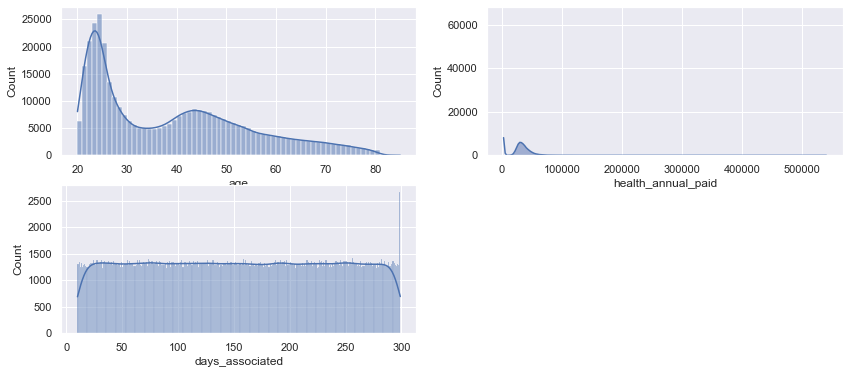

In [174]:
plt.subplot(2,2,1)
sns.histplot(df1['age'], binwidth=1, kde=True);
plt.subplot(2,2,2)
sns.histplot(df1['health_annual_paid'], kde=True);
plt.subplot(2,2,3)
sns.histplot(df1['days_associated'], binwidth=1, kde=True);

In [176]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511591,0.672539,-0.565655
1,health_annual_paid,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087,34.004569
2,days_associated,10.0,299.0,289.0,154.347397,154.0,83.671194,0.003030,-1.200688


Highlights:

age: mean = 36y, 1 std = 15.5  -->  68% of ages are between 20,5 and 51,5 y

health_annual_premium: very big range of 537535, high kurtosis, many extreme values.


days_associated: The policy paid is for 12 months, thats why the max number of days a customer is health insured is 299. 


### Cathegorical Attributes

In [178]:
#variations of each column
print( cat_attributes.apply( lambda x: x.unique() ) ,'\n')
print( cat_attributes.apply( lambda x: x.unique().shape[0] ) )

gender                                                     [Male, Female]
region_code             [28, 3, 11, 41, 33, 6, 35, 50, 15, 45, 8, 36, ...
policy_sales_channel    [26, 152, 160, 124, 14, 13, 30, 156, 163, 157,...
driving_license                                                    [1, 0]
vehicle_age                               [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                                                  [Yes, No]
vehicle_prev_insured                                               [0, 1]
response                                                           [1, 0]
dtype: object 

gender                    2
region_code              53
policy_sales_channel    155
driving_license           2
vehicle_age               3
vehicle_damage            2
vehicle_prev_insured      2
response                  2
dtype: int64


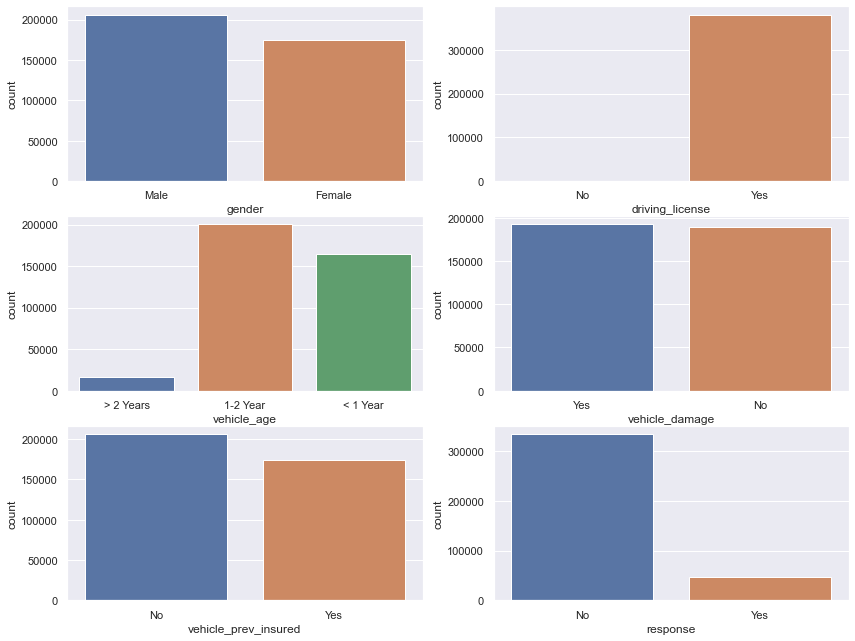

In [179]:
plt.subplots_adjust(top=1.5)

plt.subplot (3,2,1)
sns.countplot (x = cat_attributes['gender']);

plt.subplot (3,2,2)
sns.countplot (x = cat_attributes['driving_license']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,2,3)
sns.countplot (x = cat_attributes['vehicle_age']);

plt.subplot (3,2,4)
sns.countplot (x = cat_attributes['vehicle_damage']);

plt.subplot (3,2,5)
sns.countplot (x = cat_attributes['vehicle_prev_insured']);
plt.xticks([0,1],['No','Yes']);

plt.subplot (3,2,6)
sns.countplot (x = cat_attributes['response']);
plt.xticks([0,1],['No','Yes']);

In [180]:
round(cat_attributes['response'].value_counts() / cat_attributes['response'].shape[0] * 100 ,2)

0    87.74
1    12.26
Name: response, dtype: float64

Highlights:

- 12% of customers answered to be interested in a vehicle insurance.



In [181]:
df1

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,> 2 Years,Yes,0,44617.0,74,0


In [182]:
#save dataset 
df1.to_csv(datapath+'data_description_done.csv', index=False)

# Feature Engeneering

In [183]:
df2 = pd.read_csv(datapath+'data_description_done.csv')
df2

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,1-2 Year,No,1,30170.0,88,0
381105,381106,Male,30,37,152,1,< 1 Year,No,1,40016.0,131,0
381106,381107,Male,21,30,160,1,< 1 Year,No,1,35118.0,161,0
381107,381108,Female,68,14,124,1,> 2 Years,Yes,0,44617.0,74,0


## Hypotheses mindmap

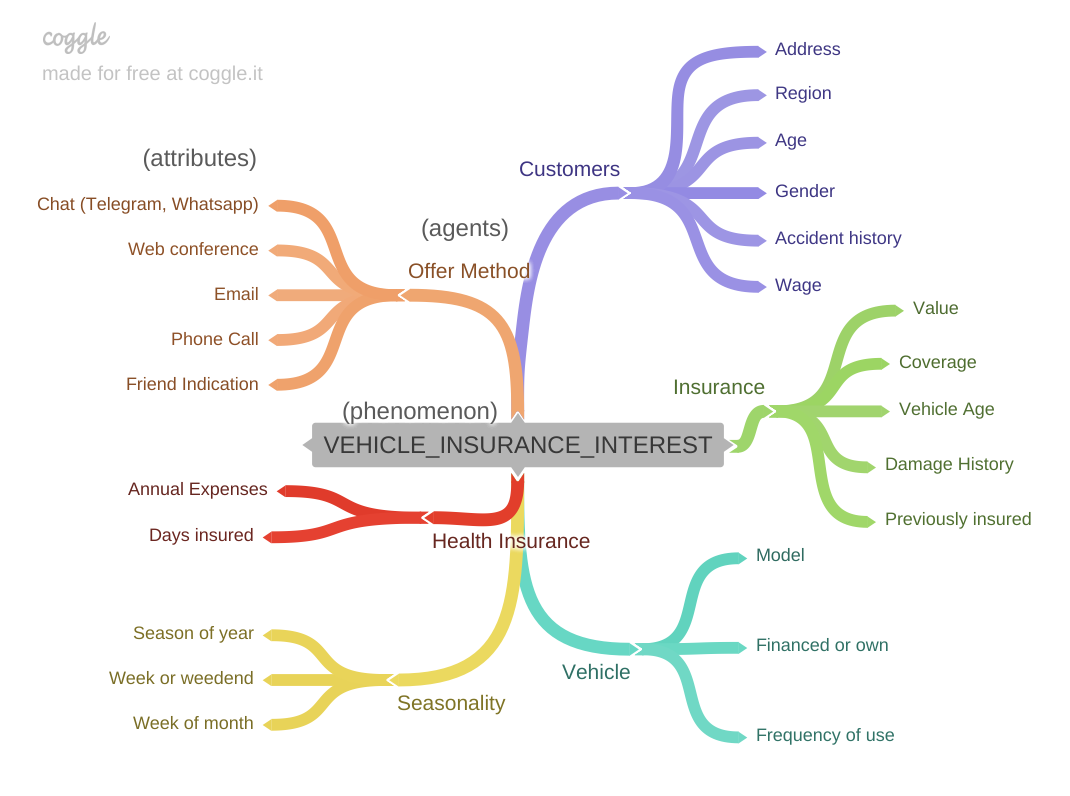

In [184]:
#hypotheses mindmap
Image( imagepath+'mindmap_hypotheses.png' )


## Hypotheses creation

In [186]:
df2.head()


,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3,26,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28,26,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11,152,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41,152,1,< 1 Year,No,1,27496.0,39,0


In [188]:
#Created hypotheses with available dataset data
tab = [['ID', 'Hypotheses'],
################################################################################
        ['H1', 'Customers with AGE HIGHER should be MORE interested.'],
        ['H2', 'Customers with GENDER FEMALE should be MORE interested.'],
        ['H3', 'Customers of CERTAINS REGION should be MORE interested.'],
        ['H4', 'Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.'],
        ['H5', 'Customers with MOST RECENT VEHICLE AGE should be MORE interested.'],
        ['H6', 'Customers who HAD VEHICLE DAMAGE should be MORE interested.'],
        ['H7', 'Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested.'],
        ['H8', 'Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested.'],
        ['H9', 'Customers whth MORE DAYS ASSOCIATED should be MORE interested.']]

################################################################################
print(tabulate(tab, headers='firstrow', stralign='left', tablefmt='pipe')) #tablefmt='pipe', tablefmt='grid'

| ID   | Hypotheses                                                              |
|:-----|:------------------------------------------------------------------------|
| H1   | Customers with AGE HIGHER should be MORE interested.                    |
| H2   | Customers with GENDER FEMALE should be MORE interested.                 |
| H3   | Customers of CERTAINS REGION should be MORE interested.                 |
| H4   | Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.     |
| H5   | Customers with MOST RECENT VEHICLE AGE should be MORE interested.       |
| H6   | Customers who HAD VEHICLE DAMAGE should be MORE interested.             |
| H7   | Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested. |
| H8   | Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested. |
| H9   | Customers whth MORE DAYS ASSOCIATED should be MORE interested.          |


## Hypotheses priorization

In [189]:
#All hypotheses can be analysed on first CRISP cycle
pass

## Feature engeneering


In [10]:
df2['vehicle_age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: vehicle_age, dtype: int64

In [190]:
dict_vehicle_age = { '> 2 Years':'over_2_years', '1-2 Year':'between_1_2_years', '< 1 Year': 'below_1_year' }
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
df2['vehicle_age'].value_counts()

between_1_2_years    200316
below_1_year         164786
over_2_years          16007
Name: vehicle_age, dtype: int64

In [191]:
df2['vehicle_damage'].value_counts()

Yes    192413
No     188696
Name: vehicle_damage, dtype: int64

In [192]:
dict_vehicle_age = {'Yes': 1, 'No':0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_age)
df2['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

In [193]:
df2

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,1,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,1,below_1_year,0,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,1,between_1_2_years,0,1,30170.0,88,0
381105,381106,Male,30,37,152,1,below_1_year,0,1,40016.0,131,0
381106,381107,Male,21,30,160,1,below_1_year,0,1,35118.0,161,0
381107,381108,Female,68,14,124,1,over_2_years,1,0,44617.0,74,0


## Variable Filtering

In [194]:
#keep just customers with drivers_licence
df2_aux = df2[df2['driving_license'] == 1]
df2 = df2_aux.drop('driving_license', axis=1)
df2

,id,gender,age,region_code,policy_sales_channel,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,below_1_year,0,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,26,26,between_1_2_years,0,1,30170.0,88,0
381105,381106,Male,30,37,152,below_1_year,0,1,40016.0,131,0
381106,381107,Male,21,30,160,below_1_year,0,1,35118.0,161,0
381107,381108,Female,68,14,124,over_2_years,1,0,44617.0,74,0


In [195]:
#no business related data needed to exclude
pass

In [196]:
df2.to_csv(datapath+'feature_engeneering_done.csv', index=False)

# Exploratory Data Analysism

In [197]:
df3 = pd.read_csv(datapath+'feature_engeneering_done.csv')
df3

,id,gender,age,region_code,policy_sales_channel,vehicle_age,vehicle_damage,vehicle_prev_insured,health_annual_paid,days_associated,response
0,1,Male,44,28,26,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,between_1_2_years,0,0,33536.0,183,0
2,3,Male,47,28,26,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,below_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,below_1_year,0,1,27496.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
380292,381105,Male,74,26,26,between_1_2_years,0,1,30170.0,88,0
380293,381106,Male,30,37,152,below_1_year,0,1,40016.0,131,0
380294,381107,Male,21,30,160,below_1_year,0,1,35118.0,161,0
380295,381108,Female,68,14,124,over_2_years,1,0,44617.0,74,0


## Univariate Analysis (needed? - review..)


- 12% of current customers are interested in vehicle insurance.

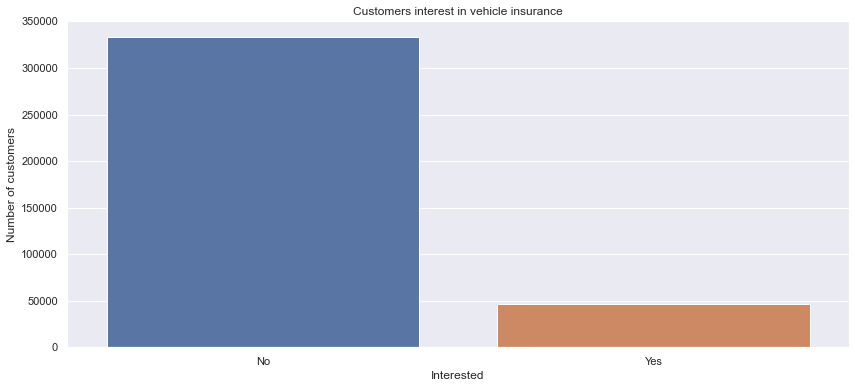

In [204]:
uni_resp = sns.countplot(x = 'response', data = df3)
uni_resp.set_ylabel('Number of customers')
uni_resp.set_xlabel('Interested')
uni_resp.set_xticklabels(['No', 'Yes']);
uni_resp.set_title('Customers interest in vehicle insurance');

In [883]:
#proportion
round(df3['response'].value_counts() / df3.shape[0] * 100 ,2)

0    87.73
1    12.27
Name: response, dtype: float64

In [ ]:
FAÇO IGUAL A UNIVARIADA, SENDO QUE JÁ FIZ ISSO NA DESCRIPTIPTIVE STATISTICAL?

### Response variable

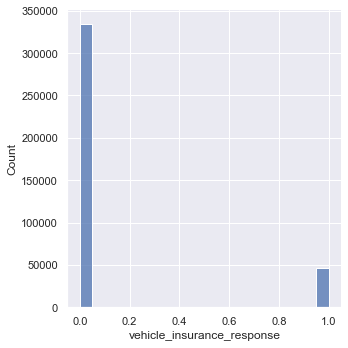

In [126]:
sns.displot(df3['vehicle_insurance_response']);

### Numerical variables

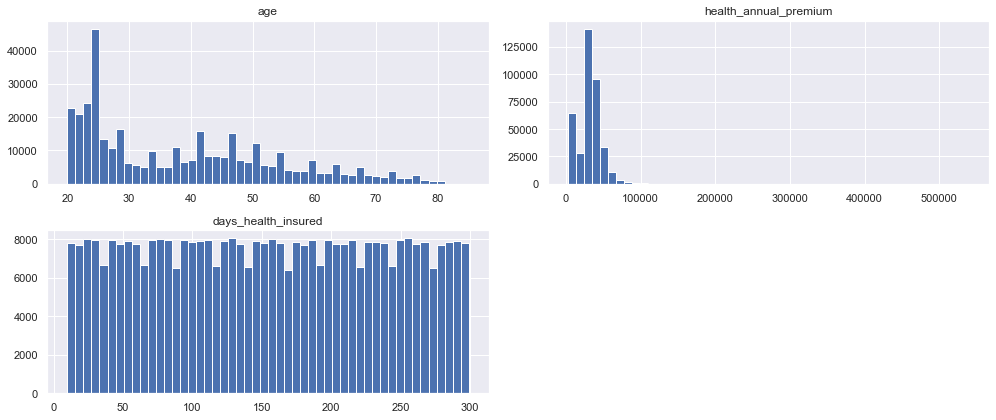

In [130]:
num_attributes.hist( bins=50 )
plt.tight_layout()

### Cathegorical Variables

In [131]:
cat_attributes.head()

,gender,region_code,id_contact_code,driving_license,vehicle_age,vehicle_damage,vehicle_previously_insured,vehicle_insurance_response
0,Male,28.0,26.0,1,> 2 Years,Yes,0,1
1,Male,3.0,26.0,1,1-2 Year,No,0,0
2,Male,28.0,26.0,1,> 2 Years,Yes,0,1
3,Male,11.0,152.0,1,< 1 Year,No,1,0
4,Female,41.0,152.0,1,< 1 Year,No,1,0


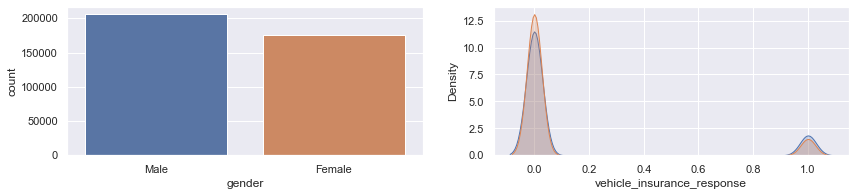

In [150]:
plt.subplot( 2,2,1 )
sns.countplot( x=df3['gender'] );

plt.subplot( 2,2,2 )
sns.kdeplot( df3[df3['gender']=='Male']['vehicle_insurance_response'], shade=True, label='Male');
sns.kdeplot( df3[df3['gender']=='Female']['vehicle_insurance_response'], shade=True, label='Female');


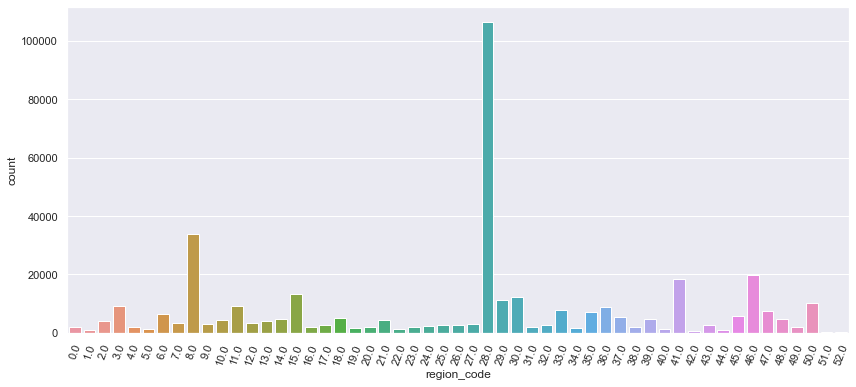

In [160]:
sns.countplot(x= df3['region_code'] )
plt.xticks(rotation=70);


## Bivariate Analysis

Validate hypotheses:

| ID   | Hypotheses                                                              |
|:-----|:------------------------------------------------------------------------|
| H1   | Customers with AGE HIGHER should be MORE interested.                    |
| H2   | Customers with GENDER FEMALE should be MORE interested.                 |
| H3   | Customers of CERTAINS REGION should be MORE interested.                 |
| H4   | Customers of CERTAIN POLICY SALES CHANEL should be MORE interested.     | 
| H5   | Customers with MOST RECENT VEHICLE AGE should be MORE interested.       |
| H6   | Customers who HAD VEHICLE DAMAGE should be MORE interested.             |
| H7   | Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested. |
| H8   | Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested. |
| H9   | Customers whth MORE DAYS ASSOCIATED should be MORE interested.          |


### H1   | Customers with AGE HIGHER should be MORE interested. (=>  false)

- Middle Age customers are the most interested in vehicle insurance. Their mean age is 43 years.

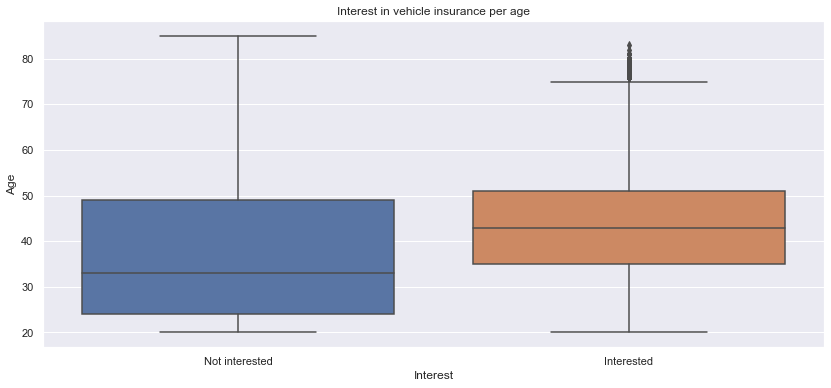

In [694]:
#distribution of interested by age
box_h1 = sns.boxplot(x = 'response', y= 'age', data = df3)
box_h1.set_xticklabels(['Not interested', 'Interested']);
box_h1.set_ylabel('Age')
box_h1.set_xlabel('Interest')
box_h1.set_title('Interest in vehicle insurance per age');

In [908]:
#mean age of interested
df3_resp_yes = df3[df3['response']==1]
round(df3_resp_yes['age'].mean() ,1)

43.4

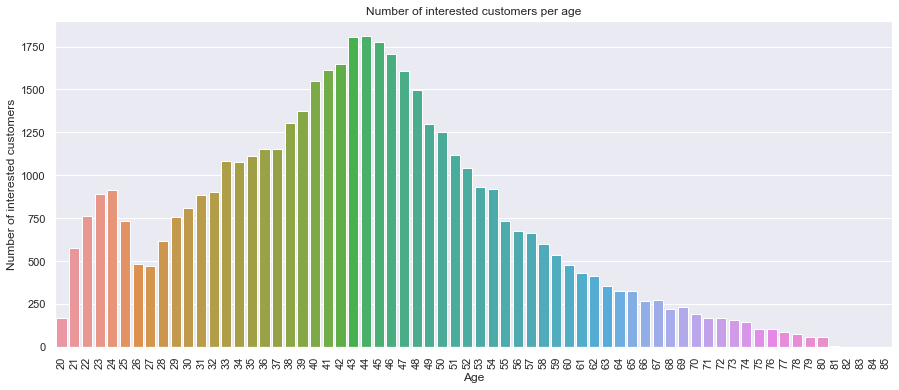

In [962]:
#analyse just interested customers and group by age
aux_h1 = df3[['age', 'response']].groupby('age').sum().reset_index()
bar_h1 = sns.barplot( x='age', y='response', data=aux_h1 )
bar_h1.set_xlabel('Age')
bar_h1.set_ylabel('Number of interested customers')
bar_h1.set_title('Number of interested customers per age')
plt.xticks( rotation=90 );

### H2   | Customers with GENDER FEMALE should be MORE interested. (=> false)

-  54% of customers are male. 61% of interested customers in vehicle insurance are male.

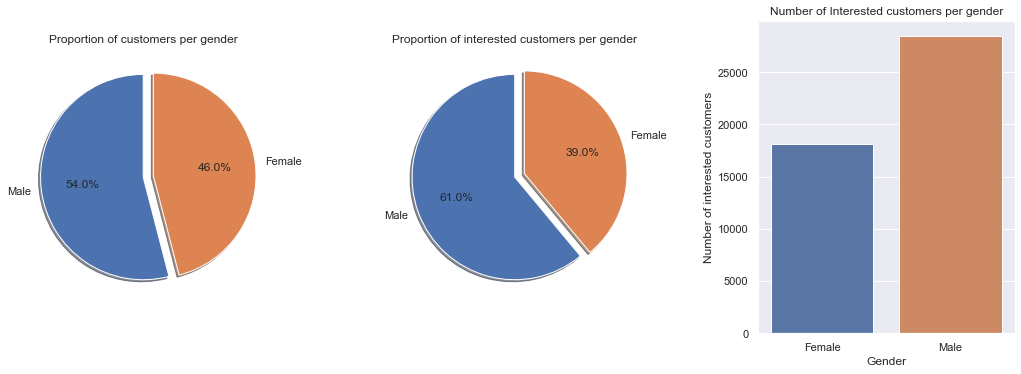

In [965]:
#charts size
plt.rcParams["figure.figsize"] = (15, 6)

#percentage of customers per gender
pie1_h2 = plt.subplot (1,3,1)
pie1_h2.set_title('Proportion of customers per gender')
perc_m, perc_f = df3['gender'].value_counts() / df3.shape[0] * 100
pie1_h2.pie([perc_m, perc_f], explode=(0, 0.1), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True, startangle=90)

# percentage of interested customers per gender
pie2_h2 = plt.subplot (1,3,2)
pie2_h2.set_title('Proportion of interested customers per gender')
aux_h2 = df3[['gender', 'response']].groupby('gender').sum().reset_index()
perc_int_f  = round( aux_h2['response'][0] / df3.shape[0] * 100 ,2)
perc_int_m = round( aux_h2['response'][1] / df3.shape[0] * 100 ,2)           
pie2_h2.pie([perc_int_m, perc_int_f], explode=(0, 0.1), labels=['Male', 'Female'], autopct='%1.1f%%', shadow=True, startangle=90);

#now absolute number of interested customers per gender
bar_h2 = plt.subplot (1,3,3)
bar_h2.set_title('Number of Interested customers per gender')
bar_h2 = sns.barplot( x='gender', y='response', data=aux_h2);
bar_h2.set_xlabel('Gender')
bar_h2.set_ylabel('Number of interested customers')

plt.tight_layout(pad=3)

### H3   | Customers of CERTAINS REGION should be MORE interested. (=> true)

- Region 28 has 28% of total customers, and 43% of interested customers!

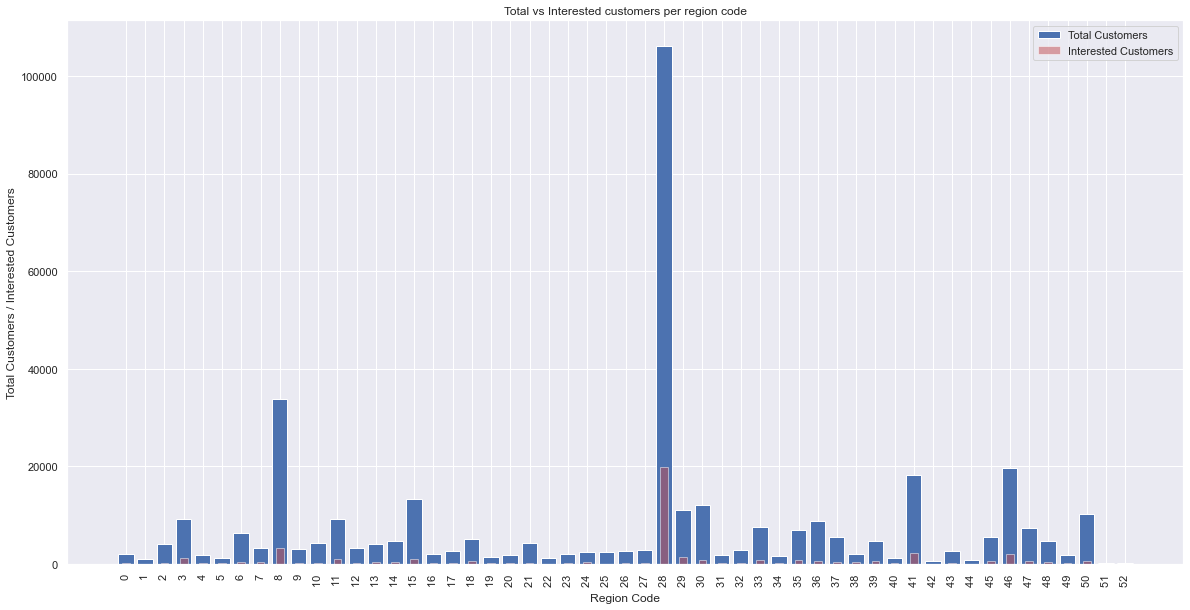

In [1073]:
#total vs interested customers per region code
width = 0.8
tot_cust_raw = df3[['region_code', 'response']].groupby('region_code').count().reset_index()
tot_cust = list(tot_cust_raw['response'])
int_cust_raw = df3[['region_code', 'response']].groupby('region_code').sum().reset_index()
int_cust = list(int_cust_raw['response'])
indices = np.arange(len(tot_cust))

plt.bar(indices, tot_cust, width=width, color='b', label='Total Customers')
plt.bar([i+0.01*width for i in indices], int_cust, width=0.5*width, color='r', alpha=0.5, label='Interested Customers')
plt.xticks(indices+width/100,[' {}'.format(i) for i in range(len(tot_cust))] )
plt.xticks( rotation=90 );
plt.title('Total vs Interested customers per region code')
plt.xlabel('Region Code')
plt.ylabel('Total Customers / Interested Customers')

plt.legend()
plt.show()

In [1180]:
print(f"Region 28 - Percentage of total customers: {round(tot_cust[28] / df3.shape[0] *100 ,1) }%")#27,9%
print(f"Region 28 - Percentage of interested: {round(int_cust[28] / df3[df3['response']==1].shape[0] * 100 ,1) }% ") #42.6

Region 28 - Percentage of total customers: 27.9%
Region 28 - Percentage of interested: 42.6% 


### H5   | Customers with MOST RECENT VEHICLE AGE should be MORE interested. (=> false)

- Taking proportion in account, the OLDER the vehicle age, the more interested in vehicle insurance the customer is, .




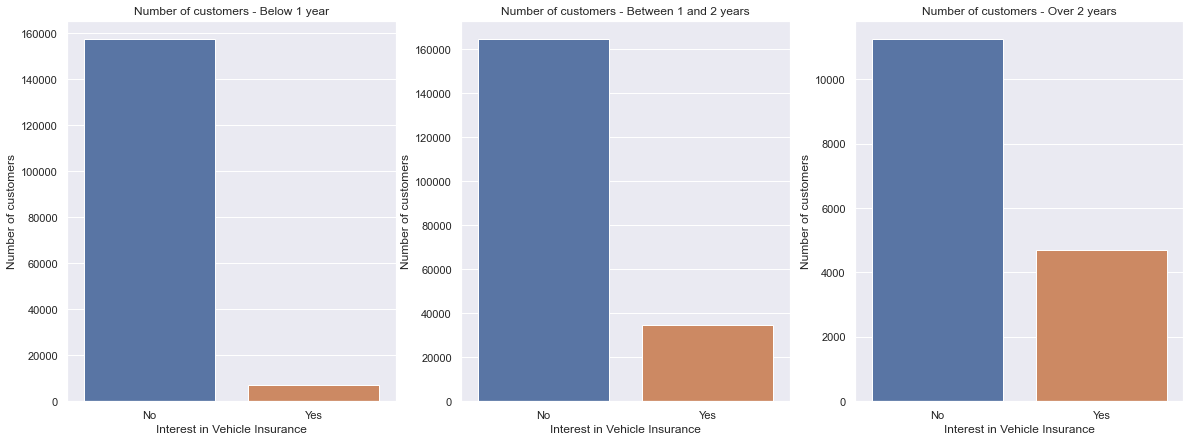

In [86]:
plt.rcParams["figure.figsize"] = (20, 7)

plt.subplot (1,3,1)
h5_df_below = df3.loc[df3['vehicle_age'] == 'below_1_year']
h5_int_below = h5_df_below[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_below_h5 = sns.barplot (x = 'response', y='vehicle_age', data=h5_int_below);
fig_below_h5.set_xlabel('Interest in Vehicle Insurance')
fig_below_h5.set_ylabel('Number of customers')
fig_below_h5.set_title('Number of customers - Below 1 year');
fig_below_h5.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,2)
h5_df_between = df3.loc[df3['vehicle_age'] == 'between_1_2_years']
h5_int_between = h5_df_between[['vehicle_age', 'response']].groupby('response').count().reset_index()
fig_between_h5 = sns.barplot (x = 'response', y='vehicle_age', data=h5_int_between);
fig_between_h5.set_xlabel('Interest in Vehicle Insurance')
fig_between_h5.set_ylabel('Number of customers')
fig_between_h5.set_title('Number of customers - Between 1 and 2 years');
fig_between_h5.set_xticklabels(['No', 'Yes']);

plt.subplot (1,3,3)
h5_df_over = df3.loc[df3['vehicle_age'] == 'over_2_years']
h5_int_over = h5_df_over[['vehicle_age', 'response']].groupby('response').count().reset_index()

fig_over_h5 = sns.barplot (x = 'response', y='vehicle_age', data=h5_int_over);
fig_over_h5.set_xlabel('Interest in Vehicle Insurance')
fig_over_h5.set_ylabel('Number of customers')
fig_over_h5.set_title('Number of customers - Over 2 years');
fig_over_h5.set_xticklabels(['No', 'Yes']);

### H6   | Customers who HAD VEHICLE DAMAGE should be MORE interested. (=> true)



- Only 0.5% of customers how didn't have vehicle damaged are interestes in vehicle insurance
- 24% of customers how havd vehicle damaged are interested in vehicle insurance


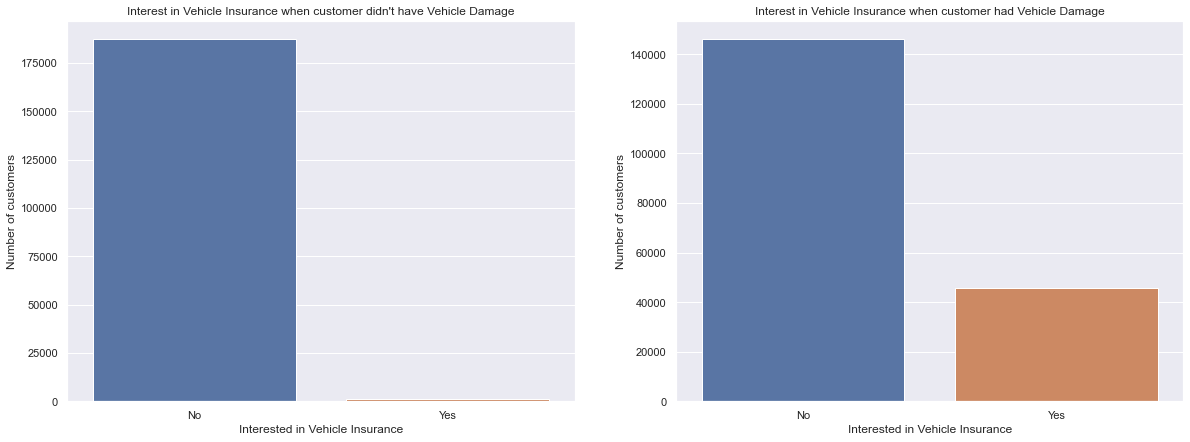

In [118]:
#get just interested and group by vehicle age 
# aux_h6 = df3[['vehicle_damage', 'vehicle_insurance_response']].groupby('vehicle_damage').count().reset_index()
#----------------

#vehicle_damage == 0(no): interested / not interested
plt.subplot (1,2,1)
h6_df_not_damaged = df3.loc[df3['vehicle_damage'] == 0]
h6_int_not_damaged = h6_df_not_damaged[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_not_damaged_h6 = sns.barplot (x = 'response', y='vehicle_damage', data=h6_int_not_damaged);
fig_not_damaged_h6.set_xlabel('Interested in Vehicle Insurance')
fig_not_damaged_h6.set_ylabel('Number of customers')
fig_not_damaged_h6.set_title('Interest in Vehicle Insurance when customer didn\'t have Vehicle Damage');
fig_not_damaged_h6.set_xticklabels(['No', 'Yes']);

#vehicle_damage == 1(yes): interested / not interested
plt.subplot (1,2,2)
h6_df_damaged = df3.loc[df3['vehicle_damage'] == 1]
h6_int_damaged = h6_df_damaged[['vehicle_damage', 'response']].groupby('response').count().reset_index()
fig_damaged_h6 = sns.barplot (x = 'response', y='vehicle_damage', data=h6_int_damaged);
fig_damaged_h6.set_xlabel('Interested in Vehicle Insurance')
fig_damaged_h6.set_ylabel('Number of customers')
fig_damaged_h6.set_title('Interest in Vehicle Insurance when customer had Vehicle Damage');
fig_damaged_h6.set_xticklabels(['No', 'Yes']);

In [133]:
h6_df_not_damaged['response'].value_counts() / h6_df_not_damaged.shape[0] *100
# Only 0.5% of customers how didn't have vehicle damage are interestes in vehicle insurance

0    99.478879
1     0.521121
Name: response, dtype: float64

In [135]:
h6_df_damaged['response'].value_counts() / h6_df_damaged.shape[0] *100
# 24% of customers how havd vehicle damage are interested in vehicle insurance

0    76.186952
1    23.813048
Name: response, dtype: float64

### H7   | Customers who HAD VEHICLE PREVIOUSLY INSURED should be MORE interested. (=> false)


- 22% of customers who didn't have vehicle previously insured are interested in vehicle insurance.
- Only 1% of customers who had vehicle previously insured are interested in vehicle insurance.


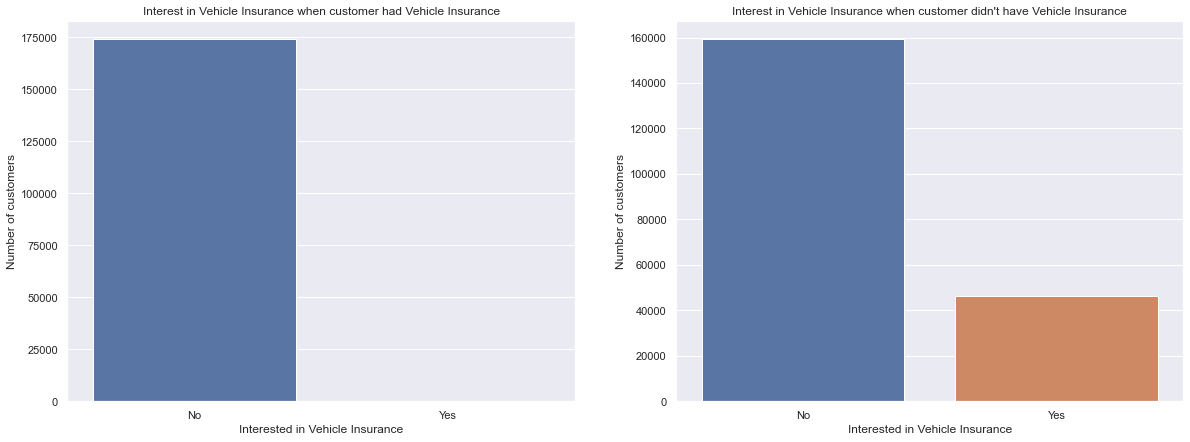

In [116]:
#vehicle_previously_insured == 1(yes): interested / not interested
plt.subplot (1,2,1)
h7_df_insured = df3.loc[df3['vehicle_previously_insured'] == 1]
h7_int_insured = h7_df_insured[['vehicle_previously_insured', 'response']].groupby('response').count().reset_index()
fig_insured_h7 = sns.barplot (x = 'response', y='vehicle_previously_insured', data=h7_int_insured);
fig_insured_h7.set_xlabel('Interested in Vehicle Insurance')
fig_insured_h7.set_ylabel('Number of customers')
fig_insured_h7.set_title('Interest in Vehicle Insurance when customer had Vehicle Insurance');
fig_insured_h7.set_xticklabels(['No', 'Yes']);

#vehicle_previously_insured == 0(no): interested / not interested
plt.subplot (1,2,2)
h7_df_not_insured = df3.loc[df3['vehicle_previously_insured'] == 0]
h7_int_not_insured = h7_df_not_insured[['vehicle_previously_insured', 'response']].groupby('response').count().reset_index()
fig_not_insured_h7 = sns.barplot (x = 'response', y='vehicle_previously_insured', data=h7_int_not_insured);
fig_not_insured_h7.set_xlabel('Interested in Vehicle Insurance')
fig_not_insured_h7.set_ylabel('Number of customers')
fig_not_insured_h7.set_title('Interest in Vehicle Insurance when customer didn\'t have Vehicle Insurance');




fig_not_insured_h7.set_xticklabels(['No', 'Yes']);

In [114]:
h7_df_insured['response'].value_counts() / h7_df_insured['response'].shape[0] *100
#1% of customers who had vehicle previously insured are interested in vehicle insurance.

0    99.909397
1     0.090603
Name: response, dtype: float64

In [115]:
h7_df_not_insured['response'].value_counts() / h7_df_not_insured['response'].shape[0] *100
#22% of customers who didn't have vehicle previously insured are interested in vehicle insurance.

0    77.411976
1    22.588024
Name: response, dtype: float64

### H8   | Customers with HIGHER ANNUAL HEALTH EXPANSES should be MORE interested.

In [ ]:
#distribution of interested by age
box_h8 = sns.boxplot(x = 'response', y= 'health_annual_premium', data = df3)
box_h8.set_xticklabels(['Not interested', 'Interested']);
box_h8.set_ylabel('Health Annual ')
box_h8.set_xlabel('Interest')
box_h8.set_title('Interest in vehicle insurance per age');

### H9   | Customers whth MORE DAYS OF HEALTH INSURANCE should be MORE interested.

## Multivariate Analysis